<h2> Age Prediction

In [5]:
# Configure GPU

import sys

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from tokenizers import Tokenizer
import numpy as np
import utils

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import random


# For reproducibility
np.random.seed(42)
torch.manual_seed(42)
cudnn.benchmark = True


In [2]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Compiled with CUDA:", torch.version.cuda)
print("GPU support enabled:", torch.backends.cuda.is_built())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch version: 2.7.0+cu126
CUDA available: True
Compiled with CUDA: 12.6
GPU support enabled: True
Using device: cuda


In [3]:
meta_tokens= pd.read_csv("/home/hrs675/Wearables_Tokenizer/data/meta_tokens.csv")

In [4]:
# Your raw inputs
X = meta_tokens['token_string']
Y = meta_tokens['age']


# === Encode labels ===
le = LabelEncoder()
Y_encoded = le.fit_transform(Y)

# Load your tokenizer
tokenizer = Tokenizer.from_file("/home/hrs675/Wearables_Tokenizer/Trained Tokenizers/trained_tokenizer_2.json")

def encode_token_string(tokenizer, s, max_len=512):
    ids = tokenizer.encode(s).ids
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

X_ids = [encode_token_string(tokenizer, s) for s in X]

In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


age
18-29    43
30-37    37
38-52    37
53+      34
Name: count, dtype: int64


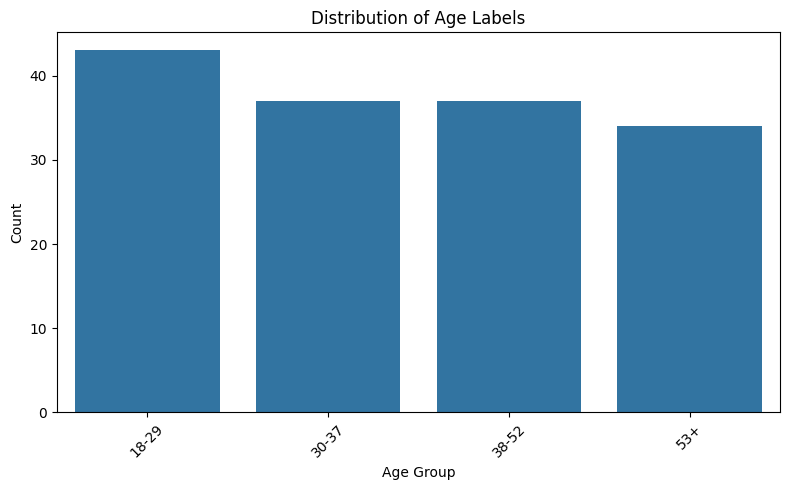

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming meta_tokens is your DataFrame and Y = meta_tokens['age']
age_counts = meta_tokens['age'].value_counts().sort_index()
print(age_counts)

plt.figure(figsize=(8, 5))
sns.countplot(x='age', data=meta_tokens, order=sorted(meta_tokens['age'].unique()))
plt.title('Distribution of Age Labels')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
vocab = set(token for string in X for token in string.split())
print(len(vocab))

10389


In [8]:
token2id = {token: idx+1 for idx, token in enumerate(sorted(vocab))}
token2id['[PAD]'] = 0
print(token2id)

{'1': 1, '10': 2, '100': 3, '101': 4, '102': 5, '103': 6, '104': 7, '105': 8, '106': 9, '108': 10, '109': 11, '11': 12, '110': 13, '111': 14, '113': 15, '115': 16, '116': 17, '117': 18, '118': 19, '119': 20, '12': 21, '120': 22, '121': 23, '123': 24, '125': 25, '126': 26, '127': 27, '128': 28, '129': 29, '13': 30, '131': 31, '134': 32, '136': 33, '138': 34, '139': 35, '14': 36, '140': 37, '143': 38, '145': 39, '146': 40, '147': 41, '149': 42, '15': 43, '150': 44, '151': 45, '152': 46, '154': 47, '155': 48, '156': 49, '157': 50, '158': 51, '16': 52, '160': 53, '161': 54, '162': 55, '163': 56, '164': 57, '166': 58, '167': 59, '168': 60, '17': 61, '175': 62, '177': 63, '179': 64, '18': 65, '182': 66, '185': 67, '186': 68, '19': 69, '193': 70, '2': 71, '20': 72, '200': 73, '201': 74, '204': 75, '205': 76, '207': 77, '21': 78, '218': 79, '22': 80, '224': 81, '227': 82, '23': 83, '231': 84, '234': 85, '237': 86, '238': 87, '24': 88, '240': 89, '25': 90, '253': 91, '256': 92, '26': 93, '262':

In [ ]:
def encode_string(s, max_len=128):
    tokens = s.split()
    ids = [token2id.get(token, 0) for token in tokens[:max_len]]
    ids += [0] * (max_len - len(ids))
    return ids

X_encoded = [encode_string(s) for s in X]

print(X_encoded)

[[182, 103, 189, 1, 248, 120, 181, 69, 234, 1, 183, 1, 184, 1, 186, 1, 186, 1, 186, 1, 185, 1, 184, 1, 184, 1, 181, 1, 181, 1, 181, 1, 182, 1, 182, 1, 182, 1, 2245, 12, 6332, 1, 181, 116, 181, 103, 919, 117, 482, 71, 182, 71, 181, 103, 181, 1, 182, 1, 211, 1, 181, 1, 191, 1, 181, 1, 420, 114, 181, 119, 9980, 65, 181, 1, 1753, 52, 185, 71, 373, 71, 192, 103, 181, 83, 181, 103, 181, 1, 185, 71, 181, 71, 181, 1, 182, 71, 182, 71, 182, 1, 182, 108, 3777, 164, 181, 103, 534, 1, 8223, 1, 8153, 1, 8195, 1, 8925, 1, 5005, 1, 3843, 103, 4779, 71, 4795, 1, 4451, 71, 4375, 103], [5629, 103, 181, 117, 9817, 1, 1381, 30, 181, 71, 882, 140, 182, 117, 181, 1, 181, 162, 183, 1, 181, 128, 188, 103, 9842, 71, 197, 1, 181, 71, 183, 71, 946, 12, 1129, 1, 181, 1, 183, 1, 182, 103, 181, 52, 181, 21, 183, 1, 181, 150, 181, 117, 182, 1, 182, 117, 183, 90, 5004, 115, 181, 83, 181, 103, 181, 1, 181, 103, 5076, 1, 2085, 1, 1628, 1, 8726, 1, 7169, 1, 6060, 1, 9543, 1, 182, 1, 7431, 1, 4040, 71, 5501, 71, 2267, 10

In [15]:

# === PyTorch Dataset ===
class AgeDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.Y = torch.tensor(Y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = AgeDataset(X_encoded, Y_encoded)

Data Split

In [ ]:

# === Split into Train (80%), Val (10%), Test (10%) ===
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)


Transfomer 

In [44]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # shape: [max_len, 1, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=6, num_classes=4, max_len=128, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        #x shape: [batch_size, seq_len]
        mask = (x == 0)  # [batch_size, seq_len]
        x = self.embedding(x).permute(1, 0, 2)  # [seq_len, batch_size, d_model]
        x = self.pos_encoder(x)                # add positional encoding
        x = self.transformer(x, src_key_padding_mask=mask)  # attention mask to ignore PAD tokens
        x = torch.max(x, dim=0)[0]  # max pooling over sequence
        return self.classifier(x)



Setup

In [38]:
# === Setup ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerClassifier(vocab_size=len(token2id), num_classes=len(le.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/home/hrs675/Wearables_Tokenizer/.venv/lib64/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Train Model

In [45]:
# === Training Loop ===
train_losses, val_losses, train_accuracies, val_accuracies, test_accuracies = [], [], [], [], []

for epoch in range(30):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == Y_batch).sum().item()
        total += Y_batch.size(0)
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == Y_batch).sum().item()
            val_total += Y_batch.size(0)
    val_losses.append(val_loss / len(val_loader))
    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)

    # Test accuracy per epoch
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(dim=1)
            test_correct += (preds == Y_batch).sum().item()
            test_total += Y_batch.size(0)
    test_acc = test_correct / test_total
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch 01 | Train Loss: 0.0171 | Val Loss: 2.2518 | Train Acc: 1.0000 | Val Acc: 0.1333 | Test Acc: 0.2500
Epoch 02 | Train Loss: 0.0167 | Val Loss: 2.2495 | Train Acc: 1.0000 | Val Acc: 0.0667 | Test Acc: 0.1875
Epoch 03 | Train Loss: 0.0158 | Val Loss: 2.2553 | Train Acc: 1.0000 | Val Acc: 0.1333 | Test Acc: 0.2500
Epoch 04 | Train Loss: 0.0158 | Val Loss: 2.2589 | Train Acc: 1.0000 | Val Acc: 0.1333 | Test Acc: 0.1875
Epoch 05 | Train Loss: 0.0142 | Val Loss: 2.2795 | Train Acc: 1.0000 | Val Acc: 0.1333 | Test Acc: 0.2500
Epoch 06 | Train Loss: 0.0144 | Val Loss: 2.2959 | Train Acc: 1.0000 | Val Acc: 0.0667 | Test Acc: 0.1875
Epoch 07 | Train Loss: 0.0140 | Val Loss: 2.3066 | Train Acc: 1.0000 | Val Acc: 0.2000 | Test Acc: 0.2500
Epoch 08 | Train Loss: 0.0137 | Val Loss: 2.2978 | Train Acc: 1.0000 | Val Acc: 0.1333 | Test Acc: 0.2500
Epoch 09 | Train Loss: 0.0127 | Val Loss: 2.3122 | Train Acc: 1.0000 | Val Acc: 0.0667 | Test Acc: 0.2500
Epoch 10 | Train Loss: 0.0123 | Val Loss: 2.30

Evaluation


✅ Test Accuracy: 0.3125

Classification Report:
              precision    recall  f1-score   support

       18-29       0.40      0.40      0.40         5
       30-37       0.33      0.25      0.29         4
       38-52       0.29      0.67      0.40         3
         53+       0.00      0.00      0.00         4

    accuracy                           0.31        16
   macro avg       0.25      0.33      0.27        16
weighted avg       0.26      0.31      0.27        16



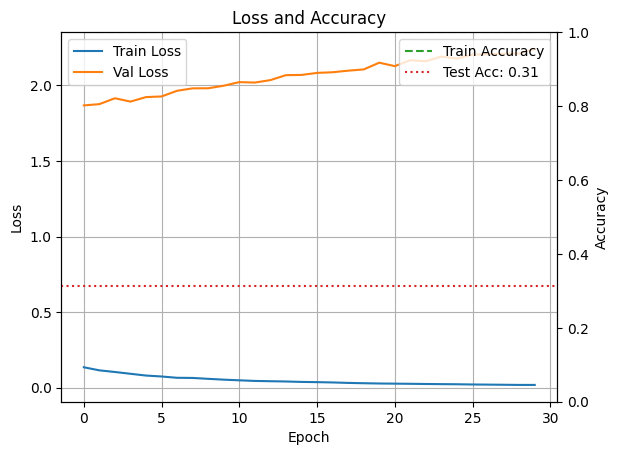


📦 Sample from Train Set:
Tokens: bbbbcbbbbbcccccccbccdcbbcccccccccccbcbcbbcbcbcbbbcbbcbbbbbccb 4 bbb 1 b 1 b 1 c 1 bbbbbbbcbbbbbbbbbbbb 1 b 1 b 1 bbbbb 1 b 1 bbbbcbbb 1 cdbbbccbccccbbbbc 2 b 1 b 1 bbbbbb 1 b 1 b 1 b 1 bbbbbcbcbbcbcbcbbbcbbcbcbccgiffdbbccccccccccccccdbbbc 1 bbb 1 cbb 1 c 5 bb 2 c 1 c 1 b 4 c 6 b 1 b 1 b 1 b 2 b 2 cbbbbbbcbbbbbcbbbdbbcbbbbbbcbcbcbbbbcbcbbbbbcgbcbccccccccbcccbcbcbcbcbbbbcbbbcbbbcbbbbbbcccccccccccccccccccccccccccccbbbbbcccccccccccccccbbbbbbbbbbbbb 1 bbb 1 bb 1 b 2 bffcccccccccccccccccccccccccccccccccccccccccccccbccbbcbcbccbcbbcbbbbcbcbcbcbcbcbcbccic 3 bcc 2 b 1 bdfd 1 bbbbdcbcccccccccccicbbbb 1 bbbbb 1 c 1 bb 1 bb 1 cbbbcbbbbcbbbbbbcbcbbcbcbbcbbcbbcbbbcbbcccbcbbcc 1 c 1 b 1 b 2 c 1 bb 2 dgbbbbcbbcgeb 1 c 2 bbbcccccccccccccccbbcbbdbdbbcbcbbcbcbbb 1 cb 1 b 1 fcbbcbbbbcbbcbbcbbcbbccbbccbccccccccccccccccccccccccccccccbcccbcdeebc 3 c 2 b 6 c 3 b 2 bb 2 b 3 b 1
True Label: 38-52
Predicted Label: 38-52

📦 Sample from Validation Set:
Tokens: 23 cbbbbbcbdbbbbbbbbb

In [42]:
# === Evaluate on Test Set ===
model.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1)
        test_correct += (preds == Y_batch).sum().item()
        test_total += Y_batch.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(Y_batch.cpu().numpy())

test_accuracy = test_correct / test_total
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# === Plot Losses and Accuracy ===
fig, ax1 = plt.subplots()
ax1.plot(train_losses, label='Train Loss', color='tab:blue')
ax1.plot(val_losses, label='Val Loss', color='tab:orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(train_accuracies, label='Train Accuracy', color='tab:green', linestyle='--')
ax2.axhline(y=test_accuracy, color='tab:red', linestyle=':', label=f'Test Acc: {test_accuracy:.2f}')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right')
plt.title('Loss and Accuracy')
plt.show()

# === Show one sample from each split ===
def show_sample(dataset_split, name):
    model.eval()
    idx = random.randint(0, len(dataset_split) - 1)
    x_sample, y_true = dataset_split[idx]
    x_sample_input = x_sample.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(x_sample_input)
        pred = output.argmax(dim=1).item()
    reverse_vocab = {v: k for k, v in token2id.items()}
    decoded_tokens = [reverse_vocab.get(tok.item(), '[UNK]') for tok in x_sample if tok.item() != 0]
    decoded_string = ' '.join(decoded_tokens)
    print(f"\n📦 Sample from {name} Set:")
    print(f"Tokens: {decoded_string}")
    print(f"True Label: {le.classes_[y_true]}")
    print(f"Predicted Label: {le.classes_[pred]}")

show_sample(train_set, "Train")
show_sample(val_set, "Validation")
show_sample(test_set, "Test")

<Figure size 600x600 with 0 Axes>

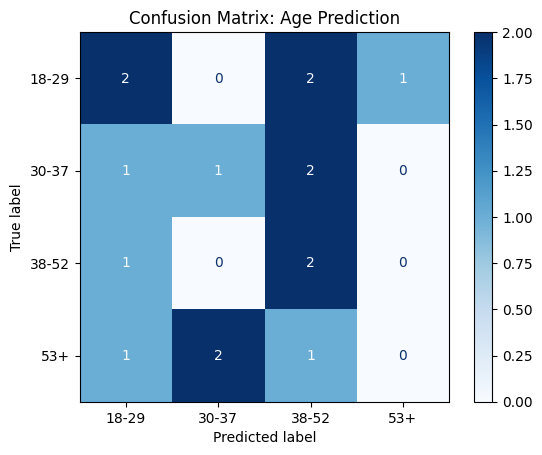

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=range(len(le.classes_)))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Age Prediction")
plt.show()